<a href="https://colab.research.google.com/github/vnlvih/Projetos_PySpark/blob/main/Video_Game_regression_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Vendas de videogames**
Este conjunto de dados contém registros de videogames populares na América do Norte, Japão, Europa e outras partes do mundo. Cada videogame neste conjunto de dados tem pelo menos 100 mil em vendas globais.

## **Apresentação dos dados**

Esse estudo irá usar os dados coletados através do site Kaggle, o qual disponibilizou o dataset em formato csv [neste link](https://www.kaggle.com/datasets/gregorut/videogamesales?resource=download). O estudo tem por objetivo construir um modelo que possa prever as vendas de video game no Japão usando as vendas na América do Norte e Europa e outras variáveis como o nome dos jogos, plataforma, genêro e etc.

## **Perguntas a serem respondidas:**

Busco responder as seguintes perguntas analisando esses dados:

- Qual dos três consoles da sétima geração (Xbox 360, Playstation 3 e Nintendo Wii) teve o maior performance de vendas globalmente?

- O que diferencia as vendas na América do Norte, na Europa e no Japão?

- Alguns gêneros são significativamente mais propensos a ter um desempenho melhor ou pior no Japão do que outros? Se sim, quais são?

In [64]:
#!pip install pyspark

In [65]:
from pyspark.sql.functions import *
from pyspark.sql.types import *


from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [66]:
df = spark.read.csv("/content/drive/MyDrive/Data Science & Afins/Projetos_portfolio/Problemas_regressão/vgsales.csv", sep =",",header=True,inferSchema=True)

In [67]:
df.show(5)

+----+--------------------+--------+----+------------+---------+--------+--------+--------+-----------+------------+
|Rank|                Name|Platform|Year|       Genre|Publisher|NA_Sales|EU_Sales|JP_Sales|Other_Sales|Global_Sales|
+----+--------------------+--------+----+------------+---------+--------+--------+--------+-----------+------------+
|   1|          Wii Sports|     Wii|2006|      Sports| Nintendo|   41.49|   29.02|    3.77|       8.46|       82.74|
|   2|   Super Mario Bros.|     NES|1985|    Platform| Nintendo|   29.08|    3.58|    6.81|       0.77|       40.24|
|   3|      Mario Kart Wii|     Wii|2008|      Racing| Nintendo|   15.85|   12.88|    3.79|       3.31|       35.82|
|   4|   Wii Sports Resort|     Wii|2009|      Sports| Nintendo|   15.75|   11.01|    3.28|       2.96|        33.0|
|   5|Pokemon Red/Pokem...|      GB|1996|Role-Playing| Nintendo|   11.27|    8.89|   10.22|        1.0|       31.37|
+----+--------------------+--------+----+------------+---------+

## **Dicionário de Dados**


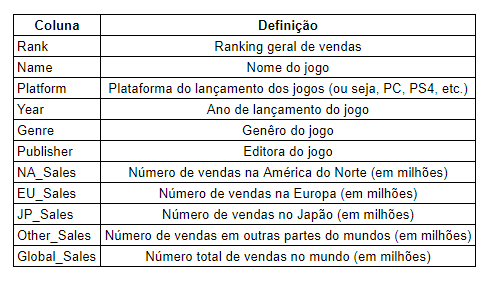



### **Data Wrangling: Preparando os dados**

Primeiramente gostária de entender a tipagem dos dados.

In [68]:
#A principio nenhuma transformação de tipagem será necessária 
df.printSchema()

root
 |-- Rank: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Platform: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- NA_Sales: double (nullable = true)
 |-- EU_Sales: double (nullable = true)
 |-- JP_Sales: double (nullable = true)
 |-- Other_Sales: double (nullable = true)
 |-- Global_Sales: double (nullable = true)



In [69]:
#Olhando as métricas estatistica das variáveis numéricas
df.select("NA_Sales","EU_Sales","JP_Sales","Other_Sales","Global_Sales").describe().show()

+-------+-------------------+------------------+-------------------+--------------------+------------------+
|summary|           NA_Sales|          EU_Sales|           JP_Sales|         Other_Sales|      Global_Sales|
+-------+-------------------+------------------+-------------------+--------------------+------------------+
|  count|              16598|             16598|              16598|               16598|             16598|
|   mean|0.26466742981084057|0.1466520062658483|0.07778166044101108|0.048063019640913515|  0.53744065550074|
| stddev| 0.8166830292988798|0.5053512312869136| 0.3092906480822022| 0.18858840291271395|1.5550279355699066|
|    min|                0.0|               0.0|                0.0|                 0.0|              0.01|
|    max|              41.49|             29.02|              10.22|               10.57|             82.74|
+-------+-------------------+------------------+-------------------+--------------------+------------------+



In [70]:
#Confirmando se temos alguma coluna com NaN.

df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

#Neste caso não temos

+----+----+--------+----+-----+---------+--------+--------+--------+-----------+------------+
|Rank|Name|Platform|Year|Genre|Publisher|NA_Sales|EU_Sales|JP_Sales|Other_Sales|Global_Sales|
+----+----+--------+----+-----+---------+--------+--------+--------+-----------+------------+
|   0|   0|       0|   0|    0|        0|       0|       0|       0|          0|           0|
+----+----+--------+----+-----+---------+--------+--------+--------+-----------+------------+



## **Data Visualization**

Buscando responder a primeira pergunta:

**Qual dos três consoles da sétima geração (Xbox 360, Playstation 3 e Nintendo Wii) teve a maior performance de vendas globalmente?**

In [71]:
%matplotlib inline
import pandas as pd #biblioteca para criação de DataFrames
import numpy as np #algebra
import seaborn as sns #graficos mais atraentes
import matplotlib.pyplot as plt #plotagem
import random #seleção de valores aleatórios para plotagem
pd.set_option("display.precision", 1)

In [72]:
df_global_platform = df.filter(col("Platform").isin(['X360','PS3','Wii'])).select("Platform","Year","Global_Sales").groupby('Platform',"Year").agg(sum("Global_Sales").alias("Global_Sales")).toPandas()

df_global_platform = df_global_platform[df_global_platform["Year"]!="N/A"]
df_global_platform = df_global_platform.pivot(index='Year',columns='Platform',values='Global_Sales').fillna(0)

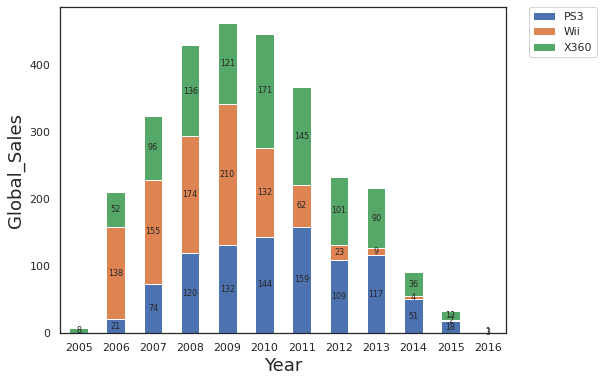

In [73]:
#create stacked bar chart
ax = df_global_platform.plot(kind='bar', stacked=True,figsize=(8, 6),rot=0, xlabel='Year', ylabel='Sum')


# .patches is everything inside of the chart
for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    # The height of the bar is the data value and can be used as the label
    label_text = f'{height:.0f}'  # f'{height:.2f}' to format decimal values
    
    # ax.text(x, y, text)
    label_x = x + width / 2
    label_y = y + height / 2

    # plot only when height is greater than specified value
    if height > 0:
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=8)
    
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)    
ax.set_ylabel("Global_Sales", fontsize=18)
ax.set_xlabel("Year", fontsize=18)
plt.show()

Podemos ver que dependendo do ano essa resposta pode variar e conforme os anos vão passando as vendas desses videos games vão descrescendo, obviamente que isso tem relação com o lançamento de modelos mais atualizados.
Mas conseguimos responder que de 2006 até 2009 os video games da Nintendo lideravam as vendas globais, comparado as três plataformas analisadas, mas a partir de 2009 até 2015 a disputa ficou entre o Xbox 360 e o Playstation 3.

Segunda pergunta:

**O que diferencia as vendas na América do Norte, na Europa e no Japão?**

In [74]:
#primeiro tentarei responder essa pergunta comparando as series historicas desses 3 lugares.
df_region = df.select("Year","NA_Sales","EU_Sales","JP_Sales").toPandas()
df_region = df_region[df_region["Year"]!="N/A"]
df_region["Year"] = df_region["Year"].astype(int)

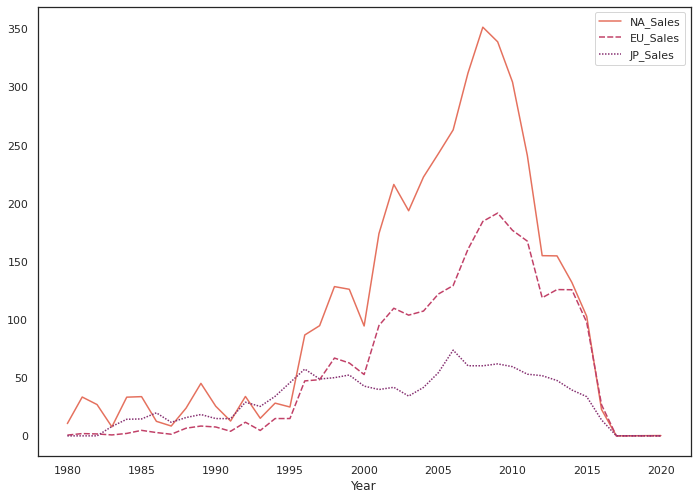

In [75]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
#set seaborn plotting aesthetics
sns.set(style='white')

sns.lineplot(data=df_region.set_index('Year'),estimator='sum',ci=None,palette="flare")

#plt.xticks(rotation=45)

Conseguimos observar que as vendas de video games na Europa e na América do Norte são maiores que as do Japão, isso pode estar relacionado as dimensões continentais dos dois primeiros quando comparados ao Japão. 
As tendencias de compras na Europa e na América do Norte também são mais semelhantes a partir do inicio dos anos 90.

Mas apenas comparando as series historicas não é o suficiente para responder nossa pergunta, portanto irei analisar as vendas separadamente olhando outros atributos.

In [76]:
df.show()

+----+--------------------+--------+----+------------+--------------------+--------+--------+--------+-----------+------------+
|Rank|                Name|Platform|Year|       Genre|           Publisher|NA_Sales|EU_Sales|JP_Sales|Other_Sales|Global_Sales|
+----+--------------------+--------+----+------------+--------------------+--------+--------+--------+-----------+------------+
|   1|          Wii Sports|     Wii|2006|      Sports|            Nintendo|   41.49|   29.02|    3.77|       8.46|       82.74|
|   2|   Super Mario Bros.|     NES|1985|    Platform|            Nintendo|   29.08|    3.58|    6.81|       0.77|       40.24|
|   3|      Mario Kart Wii|     Wii|2008|      Racing|            Nintendo|   15.85|   12.88|    3.79|       3.31|       35.82|
|   4|   Wii Sports Resort|     Wii|2009|      Sports|            Nintendo|   15.75|   11.01|    3.28|       2.96|        33.0|
|   5|Pokemon Red/Pokem...|      GB|1996|Role-Playing|            Nintendo|   11.27|    8.89|   10.22|  

In [77]:
#Analisarei separadamente os generos mais consumidos entre America do Norte, Europa e Japão buscando entender se é o genero de video game que diferencia as vendas nesses lugares.
df_pandas = df.toPandas()

df_pandas = df_pandas[df_pandas["Year"]!="N/A"]
df_pandas["Year"] = df_pandas["Year"].astype(int)


df_japan = df_pandas[['Genre',"JP_Sales"]]
df_na = df_pandas[['Genre',"NA_Sales"]]
df_eu = df_pandas[['Genre',"EU_Sales"]]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

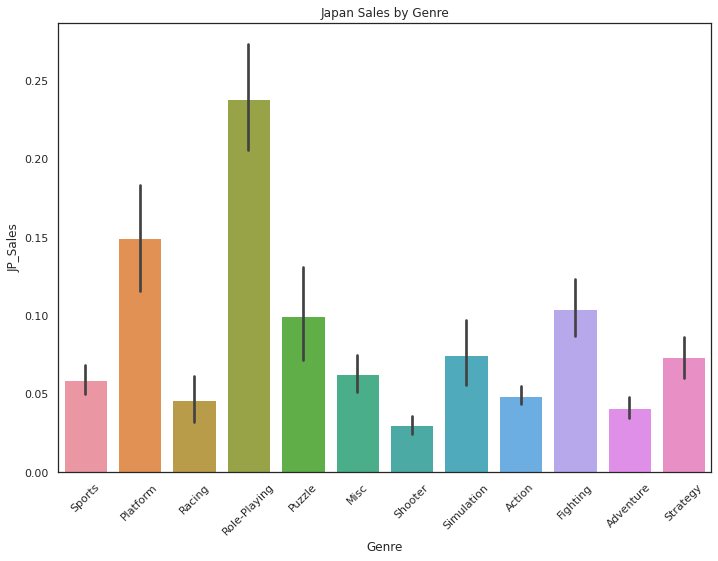

In [78]:
ax = sns.barplot(x="Genre",y="JP_Sales", data=df_japan)
plt.title("Japan Sales by Genre")
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

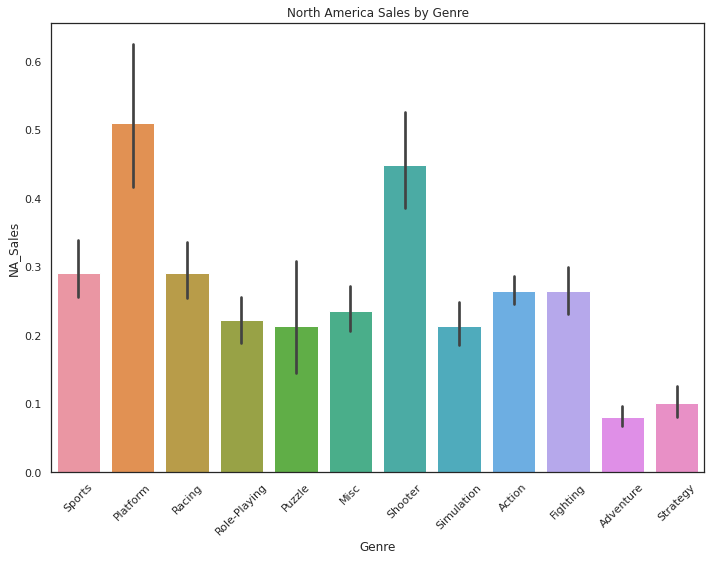

In [79]:
ax = sns.barplot(x="Genre",y="NA_Sales", data=df_na)
plt.title("North America Sales by Genre")
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

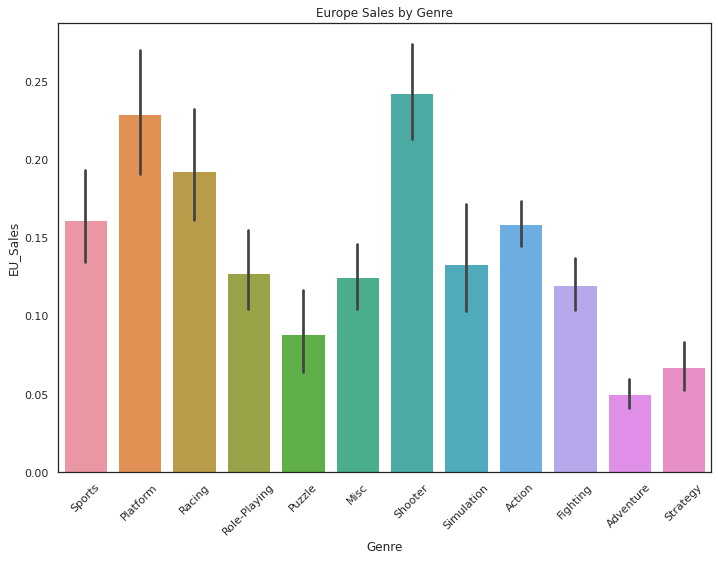

In [80]:
ax = sns.barplot(x="Genre",y="EU_Sales", data=df_eu)
plt.title("Europe Sales by Genre")
plt.xticks(rotation=45)

Analisando as vendas desses lugares já é possível notar que os gêneros mais consumidos na America do Norte e na Europa são os jogos de tiros e os jogos de plataforma, enquanto que no Japão o gênero mais consumido foi o de RPG (Role-Playing)

Terceira pergunta:

Alguns gêneros são significativamente mais propensos a ter um desempenho melhor ou pior no Japão do que outros? Se sim, quais são?

Com as analises feitas na pergunta anterior já é possível responder essa também: Sim os gêneros de RPG e Plataforma são os mais propensos a terem um desempenho melhor.

## **Prevendo as vendas de video games no Japão**

Agora vamos montar um modelo de previsão utilizando um algoritmo de Regressão para prever as vendas do Japão utilizando o atributo Gênero e as vendas da America do norte e Europa como features no modelo. O Modelo será implementado em PySpark.

### Variáveis categóricas:

 No dataset temos os atributos Genre como variáveis categóricas.
 Precisamos converter ele em indices numéricos.

In [81]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol='Genre', outputCol='genre_idx')

### One-hot enconding

A coluna Genre que é uma variável categórica nos das os seguintes gêneros de jogos:

- Adventure
- Sports
- Racing
- Role-Playing
- Shooter
- Misc
- Platform
- Puzzle
- Fighting
- Action
- Strategy
- Simulation

Essas variáveis categórias precisam virar dummies para serem utilizadas dentro do modelo de regressão.



In [83]:
from pyspark.ml.feature import OneHotEncoder

#Instanciando  o one hot encoder
onehot = OneHotEncoder(inputCols=['genre_idx'],outputCols=['genre_dummy'])

### Assembling columns

O último passo é transformar as colunas preditoras em um único vetor.

Usaremos as columnas:

- genre_dummy
- NA_Sales
- EU_Sales


In [88]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['genre_dummy','NA_Sales',"EU_Sales"], outputCol='features')

### Validação Cruzada e criação do pipeline que executará o modelo

In [95]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline


#Instanciando o modelo de regressão e o seu avaliador

regression = LinearRegression(labelCol='JP_Sales')
evaluator = RegressionEvaluator(labelCol='JP_Sales')



#Instanciando o paramdgrid poís iremos escolher os melhores pârametros para o modelo
params = ParamGridBuilder()

params = params.addGrid(regression.regParam, [0.01,0.1,1.0,10.0]) \
               .addGrid(regression.elasticNetParam, [0.0,0.5,1.0])

params = params.build()

print('Numéro de modelos que serão testados: ', len(params))

#Criando o nosso pipeline e a validação cruzada
pipeline = Pipeline(stages=[indexer,onehot,assembler,regression])

cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=params,
                    evaluator=evaluator,
                    numFolds=5)

#Separando os dados entre trieno e teste

df = df.select('Genre','NA_Sales',"EU_Sales",'JP_Sales')

df_train, df_test = df.randomSplit([.8,.2], seed=17)

Numéro de modelos que serão testados:  12


In [96]:
# Conseguindo o melhor modelo da validação cruzada

cv = cv.setSeed(13).fit(df_train)

print(cv.avgMetrics)

best_model = cv.bestModel

print(f"Extraindo os parametros do modelo: {best_model.stages[3].extractParamMap()}\n")


#Gerando as previsões no dataset de teste usando o melhor modelo e calculand oo RMSE

predictions = best_model.transform(df_test)
print(f"RMSE = {evaluator.evaluate(predictions)}")

[0.27678053948795545, 0.27700605471783796, 0.2775982700913066, 0.2747939075004054, 0.2834855834054207, 0.29524270466764585, 0.2875176242916487, 0.31015929286951005, 0.31015929286951005, 0.306289284876049, 0.31015929286951005, 0.31015929286951005]
Extraindo os parametros do modelo: {Param(parent='LinearRegression_eacdaae95fff', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2, Param(parent='LinearRegression_eacdaae95fff', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LinearRegression_eacdaae95fff', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber'): 1.35, Param(parent='LinearRegression_eacdaae95fff', name='featuresCol', doc='features column name.'): 'features', Param(parent='LinearRegression_eacdaae95fff', name='fitIntercept', doc='whether to fit an int

In [102]:
predictions.select('JP_Sales','prediction').show()

+--------+--------------------+
|JP_Sales|          prediction|
+--------+--------------------+
|    0.01|0.013316768425213583|
|    0.01|0.013316768425213583|
|    0.01|0.013316768425213583|
|    0.01|0.013316768425213583|
|    0.01|0.013316768425213583|
|    0.01|0.013316768425213583|
|    0.01|0.013316768425213583|
|    0.01|0.013316768425213583|
|    0.01|0.013316768425213583|
|    0.01|0.013316768425213583|
|    0.01|0.013316768425213583|
|    0.01|0.013316768425213583|
|    0.01|0.013316768425213583|
|    0.01|0.013316768425213583|
|    0.01|0.013316768425213583|
|    0.02|0.013316768425213583|
|    0.02|0.013316768425213583|
|    0.02|0.013316768425213583|
|    0.02|0.013316768425213583|
|    0.02|0.013316768425213583|
+--------+--------------------+
only showing top 20 rows



Fontes:

https://www.kaggle.com/datasets/gregorut/videogamesales
